# **Hybrid Rocket**

In this workbook, we introduce a hybrid training approach that can pick the most informative features from the CNN-ResBiGRU network and the Mini-Rocket transformation.

## **Initialisation**

In [2]:
pip install sktime==0.31.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 7.4 MB/s eta 0:00:00


In [24]:
import os
import numpy as np
import pickle
import itertools
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from keras.models import Model
from keras.losses import CategoricalCrossentropy
from keras.metrics import Accuracy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from keras.layers import Input, Layer, Concatenate, Lambda, Conv1D, MaxPool1D, ReLU, BatchNormalization, LayerNormalization, Dropout, Add, Dense, GlobalMaxPooling1D, Bidirectional, GRU

np.random.seed(123)

In [4]:
#You MUST run this command before reading in any data from Google Drive
from google.colab import files
from google.colab import drive
import pandas as pd
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/Thesis')

%run sys_configs.ipynb
%run plots.ipynb

Mounted at /content/drive


In [9]:
with open('data/train.npy', 'rb') as f:
    x_train = np.load(f)
    y_train = np.load(f).astype(np.int64)
sz, dim = x_train.shape[1:]

with open('data/val.npy', 'rb') as f:
    x_val = np.load(f)
    y_val = np.load(f).astype(np.int64)

with open('data/test.npy', 'rb') as f:
    x_test = np.load(f)
    y_test = np.load(f).astype(np.int64)

classes = np.unique(y_train)

N_train = len(y_train)
N_val = len(y_val)
N_test = len(y_test)

In [10]:
# Convert the labels to tensors
train_labels_tf = tf.one_hot(y_train, 31, dtype=tf.float32)
val_labels_tf = tf.one_hot(y_val, 31, dtype=tf.float32)
test_labels_tf = tf.one_hot(y_test, 31, dtype=tf.float32)

In [11]:
C = len(set(y_train)) # Number of classes

#### **Prepare train & validation datasets**

We first produce the raw and first order differenced datasets.

In [12]:
# Convert the raw dataset to tensors
train_raw_tf = tf.convert_to_tensor(x_train[:, :-1, :], dtype=tf.float32)
val_raw_tf = tf.convert_to_tensor(x_val[:, :-1, :], dtype=tf.float32)
test_raw_tf = tf.convert_to_tensor(x_test[:, :-1, :], dtype=tf.float32)

#### **Prepare Rocket transformation train & validation datasets**

We use the *sktime* MiniRocket implementation, which is the same implementation introduced in the MiniRocket paper.

In [13]:
# Transpose the train and validation data as the format needs to be N x D x (T - 1)
x_train_ = x_train[:, :-1, :].transpose((0, 2, 1))
x_val_ = x_val[:, :-1, :].transpose((0, 2, 1))
x_test_ = x_test[:, :-1, :].transpose((0, 2, 1))

In [14]:
# Compute the MiniRocket transform and transform to tensors
minirocket_multi = MiniRocketMultivariate(num_kernels = 10000, max_dilations_per_kernel = 32)
minirocket_multi.fit(x_train_)

train_rocket_np = minirocket_multi.transform(x_train_)
val_rocket_np = minirocket_multi.transform(x_val_)
test_rocket_np = minirocket_multi.transform(x_test_)

train_rocket_tf = tf.convert_to_tensor(train_rocket_np, dtype = tf.float32)
val_rocket_tf = tf.convert_to_tensor(val_rocket_np, dtype = tf.float32)
test_rocket_tf = tf.convert_to_tensor(test_rocket_np, dtype = tf.float32)

#### **Prepare PCA transformation train & validation datasets**

In [15]:
pca_rocket = PCA(n_components=128)
pca_rocket.fit(train_rocket_np)

PCA(n_components=128)

In [16]:
train_pca_np = pca_rocket.transform(train_rocket_np)
val_pca_np = pca_rocket.transform(val_rocket_np)
test_pca_np = pca_rocket.transform(test_rocket_np)

In [17]:
train_pca_tf = tf.convert_to_tensor(train_pca_np, dtype = tf.float32)
val_pca_tf = tf.convert_to_tensor(val_pca_np, dtype = tf.float32)
test_pca_tf = tf.convert_to_tensor(test_pca_np, dtype = tf.float32)

#### **Combine input datasets**

We now prepare different Tensorflow datasets for the experiments in this workbook.

**Dataset 1: Raw + Rocket Transformation Time Series**

In [18]:
train_rr_ds = tf.data.Dataset.from_tensor_slices((train_raw_tf, train_rocket_tf, train_labels_tf))
val_rr_ds = tf.data.Dataset.from_tensor_slices((val_raw_tf, val_rocket_tf, val_labels_tf))
test_rr_ds = tf.data.Dataset.from_tensor_slices((test_raw_tf, test_rocket_tf, test_labels_tf))

# Map function to process the dataset elements
def map_rr(raw, rocket, label):
    return {"raw": raw, "rocket": rocket}, label

# Apply the mapping function
train_rr_ds = train_rr_ds.map(map_rr)
val_rr_ds = val_rr_ds.map(map_rr)
test_rr_ds = test_rr_ds.map(map_rr)

train_rr_ds = train_rr_ds.shuffle(500)

train_rr_ds = train_rr_ds.padded_batch(64)
val_rr_ds = val_rr_ds.padded_batch(64)
test_rr_ds = test_rr_ds.padded_batch(64)

**Dataset 2: Raw + Rocket PCA Transformation Time Series**

In [19]:
train_rp_ds = tf.data.Dataset.from_tensor_slices((train_raw_tf, train_pca_tf, train_labels_tf))
val_rp_ds = tf.data.Dataset.from_tensor_slices((val_raw_tf, val_pca_tf, val_labels_tf))
test_rp_ds = tf.data.Dataset.from_tensor_slices((test_raw_tf, test_pca_tf, test_labels_tf))

# Map function to process the dataset elements
def map_rp(raw, pca, label):
    return {"raw": raw, "pca": pca}, label

# Apply the mapping function
train_rp_ds = train_rp_ds.map(map_rp)
val_rp_ds = val_rp_ds.map(map_rp)
test_rp_ds = test_rp_ds.map(map_rp)

train_rp_ds = train_rp_ds.shuffle(500)

train_rp_ds = train_rp_ds.padded_batch(64)
val_rp_ds = val_rp_ds.padded_batch(64)
test_rp_ds = test_rp_ds.padded_batch(64)

## **Set up standard CNN-ResBiGRU blocks**

In [20]:
class ConvBlock(Layer):

    def __init__(self, num_filters, **kwargs):
        super().__init__(**kwargs)
        self.num_filters = num_filters

    def build(self, input_shape): # Tensorflow calls this method automatically when the object is defined
        self.conv = Conv1D(self.num_filters, kernel_size=10, strides = 1, padding="same")
        self.batch_norm = BatchNormalization()
        self.max_pool = MaxPool1D(pool_size=3, strides=1, padding="same")
        self.dropout = Dropout(0.25)

    def call(self, input):
        x = self.conv(input)
        x = self.batch_norm(x)
        x = self.max_pool(x)
        output = self.dropout(x)
        return output

In [21]:
class ResBiGRU(Layer):

    def __init__(self, h1_units, h2_units, **kwargs):
        super().__init__(**kwargs)
        self.h1_units = h1_units
        self.h2_units = h2_units

    def build(self, input_shape): # Tensorflow calls this method automatically when the object is defined
        self.gru_1 =  Bidirectional(GRU(self.h1_units, activation = None, return_sequences=True), merge_mode=None)
        self.gru_2a = GRU(self.h2_units, activation = None, return_sequences=True)
        self.gru_2b = GRU(self.h2_units, activation = None, return_sequences=True)
        self.layer_norm = LayerNormalization()

    def call(self, input):
        # In the first (hidden) RNN layer, apply the forward and backward GRU layers concurrently
        z_forward, z_backward = self.gru_1(input)

        # In the second (hidden) RNN layer, apply the forward and backward GRU layers separately
        z2_forward = self.gru_2a(z_forward)
        z2_backward = self.gru_2b(z_backward)

        # Add the output of the first RNN layer to the output of the second RNN layer
        z_forward = Add()([z_forward, z2_forward])
        z_backward = Add()([z_backward, z2_backward])

        z_forward = self.layer_norm(z_forward)
        z_backward = self.layer_norm(z_backward)

        output = tf.concat([z_forward, z_backward], axis = 2)
        return output

In [22]:
# We use early stopping as CNNResBiGRU is a high parameter network, so requires many epochs to train.
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10)

# The previous benchmark paper also made use of ReduceLROnPlateau which reduces the lesrning rate when the loss plateaus.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=10e-5)

## **Train all weights at once (PCA)**

In this experiment, we apply batch normalisation to both the component acting on the raw time series and the component acting on the Rocket.

In a since discarded experiment, we consider concatenating the two components and adding an additional fully connected layer on the combined fields.

In the experiment shown below, we follow up on the Rocket batch normalisation with a fully connected layer of 64 dimensions, in order to condense the 9,996 Rocket features into a more compact representation. This replaced the additional fully connected layer on the combined fields.

In [23]:
def RocketCNNResBiGRU(ts_raw_shape, pca_raw_shape):
    ts_raw_input = Input(shape=ts_raw_shape, name = "raw")
    pca_raw_input = Input(shape=pca_raw_shape, name = "pca")

    ts_layer = ConvBlock(num_filters = 32, name = "ConvBlock")(ts_raw_input)
    ts_layer = ConvBlock(num_filters = 32, name = "ConvBlock2")(ts_layer)
    ts_layer = ResBiGRU(h1_units = 32, h2_units = 32, name = "ResBiGRU1")(ts_layer)
    ts_layer = GlobalMaxPooling1D()(ts_layer)

    pca_layer = BatchNormalization()(pca_raw_input)
    pca_layer = Dense(64, activation="sigmoid")(pca_layer) # Compress the information into 32 dimensions

    combined_layer = Concatenate(axis = 1)([pca_layer, ts_layer])

    output_layer = Dense(C, activation="softmax")(combined_layer)
    return Model(inputs=[pca_raw_input, ts_raw_input], outputs=output_layer)

In [24]:
RocketCNNResBiGRU_model = RocketCNNResBiGRU(ts_raw_shape = (sz - 1, dim), pca_raw_shape = (128,))
RocketCNNResBiGRU_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ raw (InputLayer)          │ (None, 149, 6)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ConvBlock (ConvBlock)     │ (None, 149, 32)        │          2,080 │ raw[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pca (InputLayer)          │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ConvBlock2 (ConvBlock)    │ (None, 149, 32)        │         10,400 │ ConvBlock[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128)            │            512 │ pca[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ResBiGRU1 (ResBiGRU)      │ (None, 149, 64)        │         25,408 │ ConvBlock2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          8,256 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 64)             │              0 │ ResBiGRU1[0][0]        │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128)            │              0 │ dense[0][0],           │
│                           │                        │                │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 31)             │          3,999 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 50,655 (197.87 KB)

 Trainable params: 50,271 (196.37 KB)

 Non-trainable params: 384 (1.50 KB)

In [25]:
RocketCNNResBiGRU_model = RocketCNNResBiGRU(ts_raw_shape = (sz - 1, dim), pca_raw_shape = (128,))
RocketCNNResBiGRU_model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.90, beta_2=0.999, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])
historyR1 = RocketCNNResBiGRU_model.fit(train_rp_ds, validation_data=val_rp_ds, epochs=50, verbose = 1, callbacks = [reduce_lr, earlystopping])

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 278ms/step - accuracy: 0.2168 - loss: 3.0384 - val_accuracy: 0.5101 - val_loss: 1.7556 - learning_rate: 0.0010
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.6026 - loss: 1.5013 - val_accuracy: 0.6638 - val_loss: 1.1915 - learning_rate: 0.0010
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.7418 - loss: 1.0211 - val_accuracy: 0.7263 - val_loss: 0.9075 - learning_rate: 0.0010
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.8238 - loss: 0.7343 - val_accuracy: 0.7364 - val_loss: 0.7838 - learning_rate: 0.0010
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.8741 - loss: 0.5530 - val_accuracy: 0.7378 - val_loss: 0.7225 - learning_rate: 0.0010
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.9161 - loss: 0.4248 - val_accuracy: 0.7241 - val_loss: 0.7075 - learning_rate: 0.0010
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.9402 - loss: 0.332

In [26]:
RocketCNNResBiGRU_results_val = RocketCNNResBiGRU_model.evaluate(val_rp_ds, batch_size=128)
RocketCNNResBiGRU_results_test = RocketCNNResBiGRU_model.evaluate(test_rp_ds, batch_size=128)
print("Validation Loss: {}\nValidation Accuracy: {}".format(*RocketCNNResBiGRU_results_val))
print("Test Loss: {}\nTest Accuracy: {}".format(*RocketCNNResBiGRU_results_test))

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7343 - loss: 0.7034
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7670 - loss: 0.6780
Validation Loss: 0.6525087356567383
Validation Accuracy: 0.7449712753295898
Test Loss: 0.673008382320404
Test Accuracy: 0.7649857401847839


In [27]:
predictions_combined_val = RocketCNNResBiGRU_model.predict((val_pca_tf, val_raw_tf), batch_size=128)
predictions_combined_test = RocketCNNResBiGRU_model.predict((test_pca_tf, test_raw_tf), batch_size=128)

predictions_combined_val =tf.argmax(predictions_combined_val, axis = 1)
predictions_combined_test = tf.argmax(predictions_combined_test, axis = 1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


In [28]:
# Compare predictions against the targets
print("Validation Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_combined_val), sum(np.equal(predictions_combined_val, y_val))))
print("Test Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_combined_test), sum(np.equal(predictions_combined_test, y_test))))

Validation Data - Total predictions made: 1392. Number of correct predictions: 1037
Test Data - Total predictions made: 1051. Number of correct predictions: 804


In [41]:
with open('combination_weights.npy', 'wb') as f:
    np.save(f, RocketCNNResBiGRU_model.layers[-1].get_weights()[0])
    np.save(f, RocketCNNResBiGRU_model.layers[-1].get_weights()[1])

In [5]:
with open('combination_weights.npy', 'rb') as f:
    weights = np.load(f)
    biases = np.load(f)
    print(weights.shape)
    print(biases.shape)

(128, 31)
(31,)


Visualizing weights from the final dense layer after concatenating the CNN-ResBiGRU and MiniRocket Components


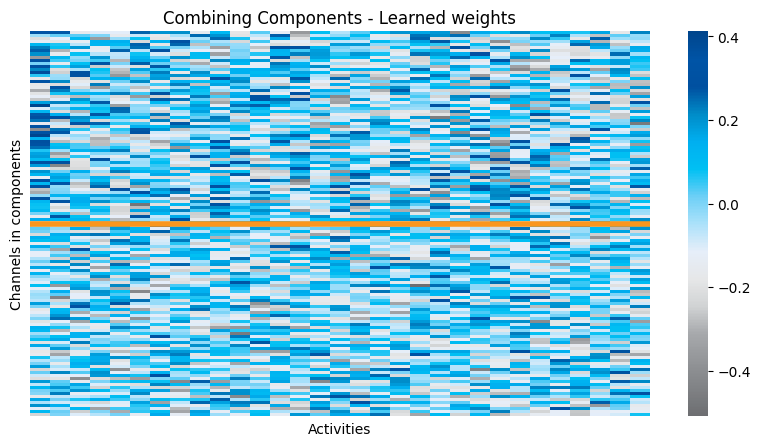

In [28]:
# Define custom colors
custom_colors = ["#6d6e71", "#808285", "#939598", "#a7a9ac", "#d1d3d4", "#e6e7e8", "#e6eef9", "#abe1fa", "#6dcff6", "#00c0f3", "#00aff0", "#008cc8", "#0050a0", "#0054a6", "#00458c"]

# Create a custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

plt.figure(figsize=(10, 5))
sns.heatmap(weights, cmap=custom_cmap, cbar=True)  # Use custom colormap

plt.title('Combining Components - Learned weights')
plt.xlabel("Activities")
plt.ylabel('Channels in components')
plt.xticks([])
plt.yticks([])
middle_row = weights.shape[0] // 2
plt.axhline(middle_row, color='#fa961e', linewidth=4)

plt.savefig("LearnedWeights.pdf", dpi = 1000, format = 'pdf', bbox_inches = 'tight')
plt.show()